## Libraries

In [3]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from scipy.stats import kde
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## The Dataset

In [6]:
df = pd.read_csv('bus.csv', header=None, low_memory=False)
df.columns = ['GPSDateTime', 'LineId', 'LineName', 'NextLevel', 'PrevLevel',
              'Strlatlon', 'ToDir', 'VehicleId', 'VehicleNo', 'unknow']

for col in df.columns:
    print(repr(col))

'GPSDateTime'
'LineId'
'LineName'
'NextLevel'
'PrevLevel'
'Strlatlon'
'ToDir'
'VehicleId'
'VehicleNo'
'unknow'


## Bus Stop Data

<Axes: >

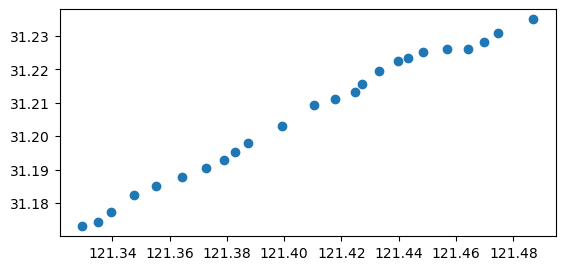

In [9]:
shp = 'busstop.json'
stop = gpd.read_file(shp, encoding='utf-8') 

stop = stop[stop['linename'] == '71路(延安东路外滩-申昆路枢纽站)']

stop.plot()

> The graph visualizes the distribution of bus stops along route 71 (Yanan East Road–Bund–Shenkun Road Hub) in Shanghai, from southwest to northeast, aligning with the actual path from the Bund toward Shenkun Road Hub. The even spacing of the stops suggests that the route is well-planned and follows rapid transit principles.

## Bus Line Data

<Axes: >

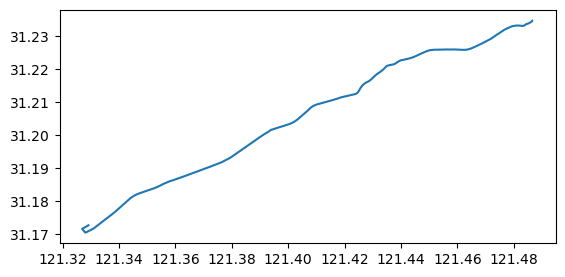

In [13]:
shp = 'busline.json'
linegdf = gpd.GeoDataFrame.from_file(shp,encoding='utf-8')

line = linegdf.iloc[:1].copy()

line.plot()

> This visualization shows the distinct bus stop locations as separate points along route 71. This visualization provides a clear representation of the spatial distribution of bus traffic, highlighting areas with higher stop density and offering insights into the route’s structure.

## Arrival and Departure Infromation

In [17]:
BUS_GPS = df.copy()

BUS_GPS = BUS_GPS[BUS_GPS['Strlatlon'] != 'Strlatlon'] 
BUS_GPS[['lon', 'lat']] = BUS_GPS['Strlatlon'].str.split(',', expand=True).astype(float)
BUS_GPS['GPSDateTime'] = pd.to_datetime(BUS_GPS['GPSDateTime'], errors='coerce')

arriveinfo = tbd.busgps_arriveinfo(BUS_GPS, line, stop)

Cleaning data...
Position matching......
Matching arrival and leaving info....................................................

In [19]:
arriveinfo

,stopname,arrivetime,leavetime,VehicleId
0,延安东路外滩,2019-01-17 07:16:40,2019-01-17 07:32:15,沪D-R0725
1,延安东路外滩,2019-01-17 09:51:22,2019-01-17 10:10:50,沪D-R0725
2,延安东路外滩,2019-01-17 12:54:13,2019-01-17 13:14:42,沪D-R0725
3,延安东路外滩,2019-01-17 15:37:00,2019-01-17 15:43:24,沪D-R0725
4,延安东路外滩,2019-01-17 18:34:27,2019-01-17 18:53:18,沪D-R0725
...,...,...,...,...
8516,吴宝路,2019-01-17 10:23:30,2019-01-17 10:54:31,沪D-T9651
8517,吴宝路,2019-01-17 12:57:54,2019-01-17 13:48:38,沪D-T9651
8518,吴宝路,2019-01-17 15:50:34,2019-01-17 15:55:34,沪D-T9651
8519,吴宝路,2019-01-17 16:02:53,2019-01-17 16:36:17,沪D-T9651


> The table above shows a descriptive analysis of bus arrival and departure times using GPS data processed with the transbigdata library. The dataset includes stop names, arrival and departure times, and vehicle identifiers. For example, bus ID Hu D-R0725 had multiple stops, including a 20-minute delay at Yanan East Road (Bund), indicating peak-hour congestion. Analyzing dwell times helps identify delays, evaluate route efficiency, and adjust schedules. Duplicated records highlight service loops and reveal temporal trends like increased congestion during rush hours.

## Bus Locations

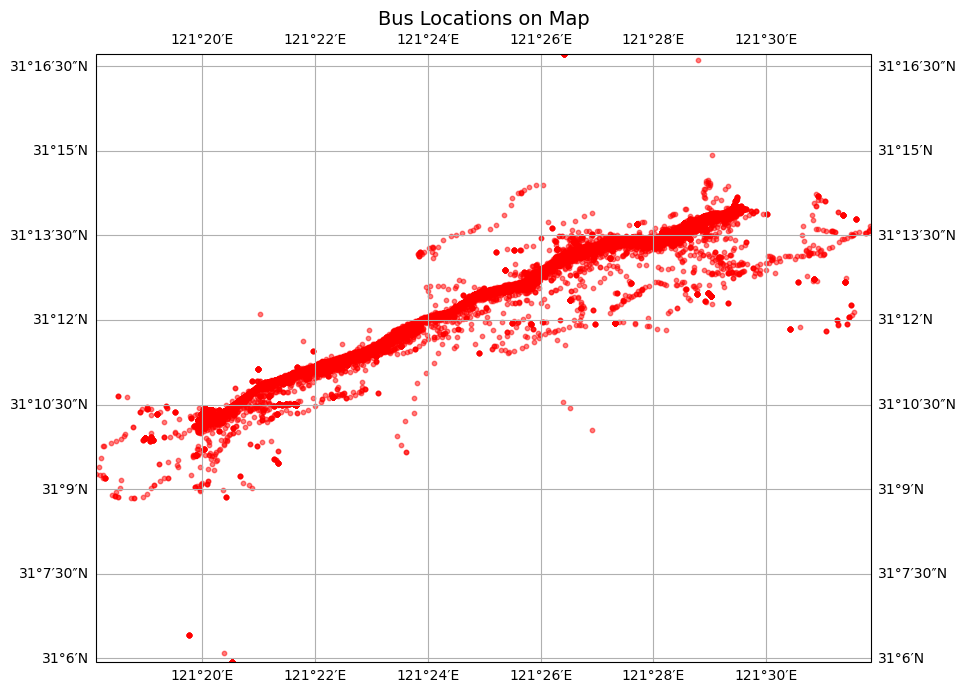

In [23]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min(BUS_GPS['lon']), max(BUS_GPS['lon']), min(BUS_GPS['lat']), max(BUS_GPS['lat'])])

ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(BUS_GPS['lon'], BUS_GPS['lat'], color='red', s=10, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_title('Bus Locations on Map', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

> The scatter plot of bus GPS locations, was created using matplotlib and cartopy. Cartopy provides geographic context through map projection, including features like coastlines and gridlines. The plot shows bus positions along a defined linear corridor, indicating a fixed-route service primarily running east-west. A higher concentration of points in the central segment suggests increased bus frequency, congestion, or a central hub. This visualization helps understand the route structure, identify operational hotspots, and serves as a foundation for further spatiotemporal analysis of public transit behavior.

## Bus Arrival and Departure Times Distribution 

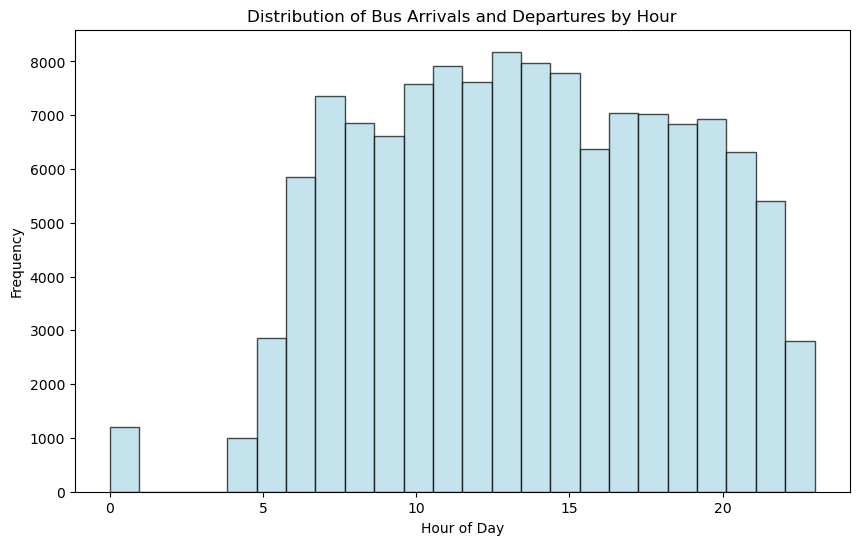

In [27]:
BUS_GPS['hour'] = BUS_GPS['GPSDateTime'].dt.hour

plt.figure(figsize=(10, 6))
BUS_GPS['hour'].plot(kind='hist', bins=24, color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Bus Arrivals and Departures by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

> The histogram illustrates bus arrivals and departures throughout the day in a histogram, revealing a peak between 7 AM and 3 PM, with the highest frequency around 1 PM. This suggests that bus usage is most intense during standard working and school hours. Activity is minimal between midnight and 4 AM. The pattern closely resembles the Hourly Net Availability seen in Figure 4 for bike traffic, indicating similar congestion trends for both buses and bikes.

## Heatmap of Bus Stops

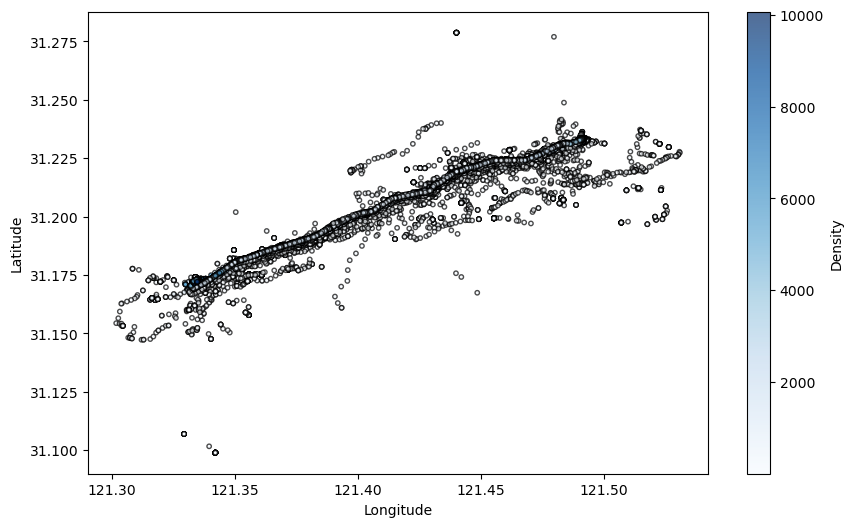

In [31]:
latitudes = BUS_GPS['lat']
longitudes = BUS_GPS['lon']

xy = np.vstack([longitudes, latitudes])
z = kde.gaussian_kde(xy)(xy)

plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, c=z, s=10, edgecolor='k', cmap='Blues', alpha=0.7)
plt.colorbar(label='Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

> The graph displays the spatial location of bus stops using a 2D kernel density estimate, showing a high concentration of stops along a linear corridor, similar to the Bus-Locations graph. This suggests that the major road or transit line serves as a dominant transportation axis. Darker blue shades indicate higher density areas, highlighting frequent stop hubs. This visualization aids in assessing bus service infrastructure and identifying potential gaps in coverage.

## Bus Routes and Stops

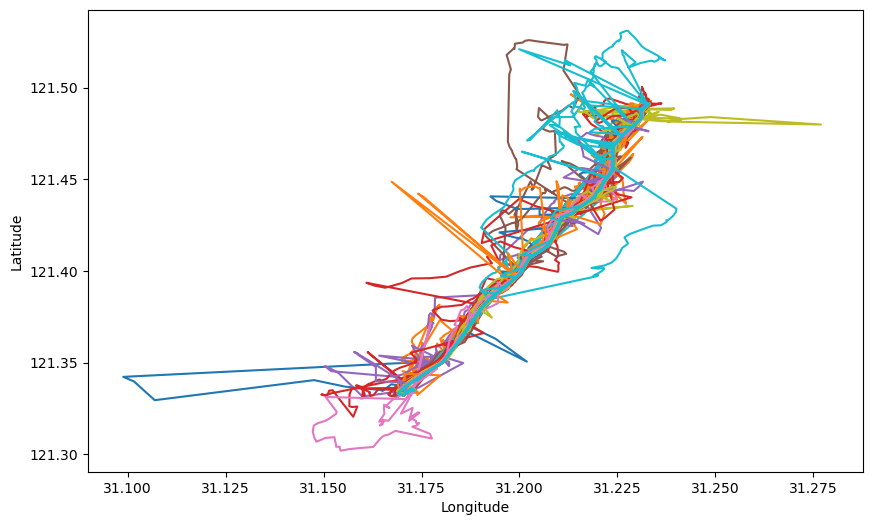

In [35]:
bus_stops = BUS_GPS[['VehicleId', 'Strlatlon', 'GPSDateTime']].drop_duplicates()

plt.figure(figsize=(10, 6))

for vehicle in bus_stops['VehicleId'].unique():
    vehicle_stops = bus_stops[bus_stops['VehicleId'] == vehicle]
    stops_lat = vehicle_stops['Strlatlon'].str.split(',', expand=True)[0].astype(float)
    stops_lon = vehicle_stops['Strlatlon'].str.split(',', expand=True)[1].astype(float)
    plt.plot(stops_lon, stops_lat)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

> The visualization above shows a visualization of GPS stop locations, depicting the paths of individual bus routes, with each line representing a different vehicle's trajectory. Overlapping and crossing routes indicate an interconnected and dense public transit network, primarily concentrated along the central corridor. This map is valuable for extending the bus network, analyzing high-traffic zones, identifying areas with redundant or insufficient coverage, and assessing route planning. It helps improve connectivity and service efficiency.